### Gaussian Mixture Models with EM Algorithm Implementation in PySpark
### Author: Yi Rong (yirong@bu.edu)
### Date: 05/02/2021
### Description: 
* GMM with EM implemented from scratch
* GMM with EM implemented from library

In [1]:
from __future__ import print_function
import sys

from operator import add
# from string import lowercase
from re import sub, search
import numpy as np
from numpy.random.mtrand import dirichlet, multinomial
from string import punctuation
import random
import time
from scipy.stats import norm
import pandas as pd
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
import matplotlib.cm as cm
from random import sample

from pyspark.sql import functions as f, udf
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.mllib.stat import Statistics
from numpy.linalg import multi_dot
from scipy.stats import multivariate_normal

In [2]:
sc = SparkContext(appName="GMM_EM")

In [3]:
n_feature = 2 # the number of features
n_components = 3 # the number of clusters

In [4]:
# generate isotropic Gaussian blobs (data from mixture Gaussian distributions)
X, y = make_blobs(n_samples=300, # the number of total samples
                  centers=n_components, # the number of clusters
                  n_features=n_feature, # the number of features
                  cluster_std = [0.8, 1.5, 1],
                  random_state=2) # 2

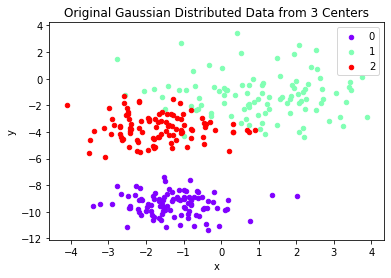

In [5]:
# scatter plot, data points annotated by different colors
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
cluster_name = set(y)
colors = dict(zip(cluster_name, cm.rainbow(np.linspace(0,1,len(cluster_name)))))
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key].reshape(1,-1))
pyplot.title('Original Gaussian Distributed Data from {} Centers'.format(n_components))
pyplot.show()

In [6]:
# read data as rdd
data_raw = sc.parallelize(X)

n_rows = data_raw.count() # the total number of samples

### 1.Assume $k$ components over $n$ data points

### Randomly assign cluster to each row of data

### pi: 

# $\pi_{j} = \frac{|c_{i}=j|}{n}$

### mean_vector: 

# $\mu_{j} =  \frac{\sum (x_{i}|c_{i}=j)}{|c_{i}=j|}$

###  covariance_matrixes: 

# $\Sigma_{j} = \frac{\sum{((x_i-\mu_{j})^{T} \cdot (x_i-\mu_{j})|c_{i}=j)} }{|c_{i}=j|-1}$

In [7]:
# assign a cluster to each row, use reminder to make sure each cluster has data
data_comp = data_raw.zipWithIndex().map(lambda x: (np.array(x[0]), x[1] % n_components))
data_comp.cache()

PythonRDD[3] at RDD at PythonRDD.scala:53

In [8]:
# Initialize pi with equal proportion
pi = [1/n_components for k in range(n_components)]

In [9]:
# Initial the mean_vector and covariance_matrixes matrix based on the formulas
mean_vector = []
covariance_matrixes = []
for  j in range(n_components):
    comp_j = data_comp.filter(lambda p: p[1] == j).map(lambda p: p[0])
    n_count = comp_j.count()
    
    mean_vector.append(comp_j.reduce(lambda x, y: x + y) / n_count)
    
    cov_sum = comp_j.map(lambda x: x - mean_vector[j])\
            .map(lambda x: np.multiply(np.reshape(x, (n_feature, 1)), x))\
            .reduce(lambda x, y: x + y)
    covariance_matrixes.append(cov_sum / (n_count-1))

### 2.E - STEP

### Calculate a "soft" assignment of each row to each cluster, which is r matrix:

# $r_{ij} = \frac{\pi_{j} N(x_{i}|\mu_{j}, \Sigma_{j})}{\sum_{c=1}^{k}\pi_{c} N(x_{i}| \mu_{c}, \Sigma_{c})}$

### 3.M - STEP

### Do an MLE for each Gaussians Cluster

### Update for mean_vector

# $\mu_{j} =  \frac{\sum_{i=1}^{n} (r_{ij} \space \times \space x_{i})}{\sum_{i=1}^{n} r_{ij}}$

### Update for covariance_matrixes

# $\Sigma_{j} = \frac{\sum_{i=1}^{n}{r_{ij} \space \times \space ((x_i-\mu_{j})^{T} \cdot (x_i-\mu_{j}))} }{\sum_{i=1}^{n} r_{ij}}$

### Update for pi list

### $\pi_{j} = \frac{\sum_{i=1}^{n} r_{ij}}{n}$

### 4.Repeat 2 and 3 max_iter times

In [10]:
max_iter = 100
for _iter in range(max_iter):
    print(_iter)
    ''' --------------------------   E - STEP   -------------------------- '''
    # Calculating the r matrix, evrey row contains the probabilities
    # for every cluster for this row
    
    # r'shape (1, n_components) and each row's sum is 1
    r = data_raw.map(lambda x: np.array([pi[j] * multivariate_normal.pdf(x, mean_vector[j], covariance_matrixes[j])\
                                     for j in range(n_components)]))\
                .map(lambda x: x / sum(x))

    # Calculating the N, the sum of r_ic, when c = j
    N = r.reduce(lambda x, y: x + y)

#     print(N)
    ''' --------------------------   M - STEP   -------------------------- '''
    # Initializing the mean_vector
    _mean_vector = np.zeros((n_components, n_feature))
    # Initiating the covariance_matrixes
    _covariance_matrixes = [np.zeros((n_feature, n_feature)) for _k in range(n_components)]
    
    # r_data_raw's row is (r_i, X_i)
    r_data_raw = r.zip(data_raw)
    r_data_raw.cache()
    for j in range(n_components):
        
        comp_j = r_data_raw.map(lambda x: x[0][j] * x[1])

        _mean_vector[j] = 1 / N[j] * comp_j.reduce(lambda x, y: x + y)

        cov_sum = r_data_raw.map(lambda x: (x[0], x[1] - mean_vector[j]))\
                .map(lambda x: x[0][j] * np.multiply(np.reshape(x[1], (n_feature, 1)), x[1]))\
                .reduce(lambda x, y: x + y)
        _covariance_matrixes[j] = 1 / N[j] * cov_sum
        
    # Update for pi list
    pi = [N[j]/n_rows for j in range(n_components)]
    # Update for mean_vector
    mean_vector = _mean_vector
    # Update for covariance_matrixes
    covariance_matrixes = _covariance_matrixes

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [12]:
''' --------------------------   Prediction   -------------------------- '''
# predict the probabilities of the 3 clusters and assign cluster with the maximal one
y_pred = data_raw.map(lambda x: [multivariate_normal.pdf(x, mean_vector[j], covariance_matrixes[j])\
                             for j in range(n_components)])\
        .map(lambda x: x.index(max(x))).collect()

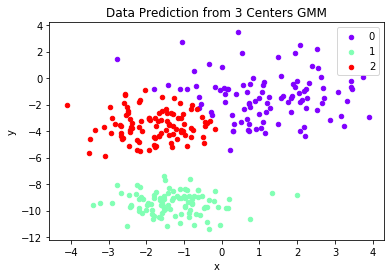

In [13]:
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y_pred))
cluster_name = set(y_pred)
colors = dict(zip(cluster_name, cm.rainbow(np.linspace(0,1,len(cluster_name)))))
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key].reshape(1,-1))
pyplot.title('Data Prediction from {} Centers GMM'.format(n_components))
pyplot.show()

###  log-likelihood of Gaussian Mixture Model

# $l(\theta)=\sum_{i=1}^{n}log(\sum_{c=1}^{k}\pi_{c} N(x_{i}| \mu_{c}, \Sigma_{c}))$

# where $\theta = \{\mu_{1},...,\mu_{k},\Sigma_{1},...,\Sigma_{k},\pi_{1},...,\pi_{k}\}$

In [14]:
llh = data_raw.map(lambda x: np.array([pi[j] * multivariate_normal.pdf(x, mean_vector[j], covariance_matrixes[j]) 
                                       for j in range(n_components)]))\
            .map(lambda x: np.log(sum(x)))\
            .reduce(lambda x, y: x + y)

In [15]:
llh

-1200.258168435339

Accuracy

In [16]:
# change labels to match original clusters
y_pred = [1 if yi == 0 else 0 if yi== 1 else yi for yi in y_pred]

In [17]:
y_pred_acc = sum(1 for x, y in zip(y, y_pred) if x == y) / float(len(y))
y_pred_acc

0.9533333333333334

### Use Library pyspark.ml.clustering.GaussianMixture

In [18]:
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.linalg import Vectors

In [19]:
spark = SparkSession \
    .builder \
    .appName("GMM-lib") \
    .getOrCreate()

In [20]:
# loads data
data_raw_v = data_raw.map(lambda x: (Vectors.dense(x.tolist()), ))
df = spark.createDataFrame(data_raw_v, ["features"])

In [21]:
gm = GaussianMixture(k=3, tol=0.0001, seed=10)
gm.setMaxIter(100)

GaussianMixture_6038dddf8336

In [22]:
model = gm.fit(df)

In [23]:
y_pred_lib = model.transform(df).select('prediction').rdd.flatMap(lambda x: x).collect()

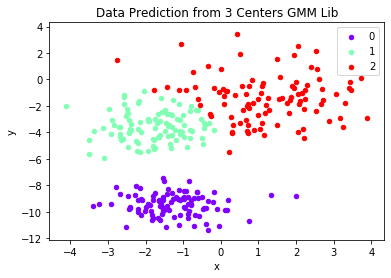

In [24]:
# scatter plot
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y_pred_lib))
cluster_name = set(y_pred)
colors = dict(zip(cluster_name, cm.rainbow(np.linspace(0,1,len(cluster_name)))))
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key].reshape(1,-1))
pyplot.title('Data Prediction from {} Centers GMM Lib'.format(n_components))
pyplot.show()

In [25]:
model.summary.logLikelihood

-1200.2380396303138

In [26]:
# change labels to match original clusters
y_pred_lib = [1 if yi == 2 else 2 if yi== 1 else yi for yi in y_pred_lib]

In [27]:
y_pred_lib_acc = sum(1 for x, y in zip(y, y_pred_lib) if x == y) / float(len(y))
y_pred_lib_acc

0.95